In [60]:
import pandas as pd

# Cargamos ignorando errores de fecha inicialmente para que no se detenga
df_estudiantes = pd.read_excel('MenteSana.xlsx', sheet_name='Estudiantes')

# Convertimos la columna 'Fecha de aplicación' a fecha real, 
# los valores erróneos (como el 6686090.0) se convertirán en NaT (Not a Time)
df_estudiantes['Fecha de aplicación'] = pd.to_datetime(df_estudiantes['Fecha de aplicación'], errors='coerce')

# Eliminamos filas que no tengan nombre de estudiante (filas basura al final)
df_estudiantes = df_estudiantes.dropna(subset=['Apellidos y nombres'])

print(f"Total de estudiantes cargados: {len(df_estudiantes)}")

Total de estudiantes cargados: 1237


/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1000 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1001 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1002 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1003 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)


In [61]:
import re

def to_camel_case(s):
    s = s.strip().lower()
    s = re.sub(r'[áà]', 'a', s)
    s = re.sub(r'[éè]', 'e', s)
    s = re.sub(r'[íì]', 'i', s)
    s = re.sub(r'[óò]', 'o', s)
    s = re.sub(r'[úù]', 'u', s)
    words = re.split(r'[\s_]+', s)
    return words[0] + ''.join(w.capitalize() for w in words[1:])

df_estudiantes.columns = [to_camel_case(c) for c in df_estudiantes.columns]
df_estudiantes.columns.tolist()

['codbusq',
 'santaC',
 'territorio',
 'ugt',
 'provincia',
 'distrito',
 'centroPoblado',
 'institucionEducativa',
 'codModular',
 'codLocal',
 'nivelModular',
 'grado',
 'seccion',
 'apellidosYNombres',
 'edad',
 'fechaDeAplicacion',
 'corteDeEvaluacion',
 'item1',
 'item2',
 'item3',
 'item4',
 'item5',
 'item6',
 'item7',
 'item8',
 'item9',
 'item10',
 '1.¿queSuelesHacerCuandoEstasEnojado?',
 '2.¿comoTeLlevasConTusCompañeros/as?¿queHacesParaLlevarteMejorConEllos/as?',
 '3.¿queHacesParaTomarBuenasDecisionesEnTuVidaDiaria?',
 '4.¿queTeGustariaAprenderOMejorarEnEstasSesiones?',
 'facilitador/a',
 'autoconciencia',
 'autocontrol',
 'concienciaSocial',
 'habilidadesRelacionales',
 'tomaDeDecisionesResponsables']

In [62]:
import unicodedata

df_estudiantes['apellidosYNombres'] = (
    df_estudiantes['apellidosYNombres']
    .str.strip()
    .str.normalize('NFKD')
    .apply(lambda x: ''.join(c for c in x if not unicodedata.combining(c)) if isinstance(x, str) else x)
)

In [63]:
# Duplicados: mismo nombre en mismo corte de evaluación
dupes = df_estudiantes[df_estudiantes.duplicated(subset=['apellidosYNombres', 'corteDeEvaluacion'], keep=False)]
dupes = dupes.sort_values(['apellidosYNombres', 'corteDeEvaluacion'])
print(f"Posibles duplicados: {len(dupes)}")
dupes[['apellidosYNombres', 'corteDeEvaluacion', 'institucionEducativa', 'grado', 'seccion']]

Posibles duplicados: 8


,apellidosYNombres,corteDeEvaluacion,institucionEducativa,grado,seccion
1020,Estrella,3er corte,TECNICO INDUSTRIAL,Pri-3ero,NaN
1193,Estrella,3er corte,86843,Pri-4rto,A
27,GUEVARA BARDALES BRITANIE CARLITA,2do corte,86221 SAN AGUSTIN,Sec-1ero,Única
1209,GUEVARA BARDALES BRITANIE CARLITA,2do corte,86221 SAN AGUSTIN,Sec-1ero,NaN
721,JAZMIN,2do corte,INDUSTRIAL PILOTO MIGUEL GRAU,Pri-5nto,U
798,JAZMIN,2do corte,86906,Pri-6xto,U
795,NEYMAR,2do corte,86906,Pri-6xto,U
799,NEYMAR,2do corte,86906,Pri-6xto,U


In [64]:
# Eliminar todas las filas que son duplicados exactos por nombre + corte
mask_dupes = df_estudiantes.duplicated(subset=['apellidosYNombres', 'corteDeEvaluacion'], keep=False)
df_estudiantes_clean = df_estudiantes[~mask_dupes]
print(f"Total estudiantes después de eliminar duplicados: {len(df_estudiantes_clean)}")

Total estudiantes después de eliminar duplicados: 1229


In [65]:
df_sesiones = pd.read_excel('Sesiones.xlsx', sheet_name='Hoja1')
df_sesiones = df_sesiones[['Sesiones Estudiante ejecutadas', 'CODIGO MODULAR']]

import re

def to_camel_case(s):
    s = s.strip().lower()
    for a, b in [('á','a'),('é','e'),('í','i'),('ó','o'),('ú','u'),('ñ','n')]:
        s = s.replace(a, b)
    s = re.sub(r'[¿?./,()°]', '', s)
    words = re.split(r'[\s_]+', s)
    return words[0] + ''.join(w.capitalize() for w in words[1:])

df_sesiones.columns = [to_camel_case(c) for c in df_sesiones.columns]
print(df_sesiones.columns.tolist())

['sesionesEstudianteEjecutadas', 'codigoModular']


In [66]:
df_estudiantes_backup = df_estudiantes_clean.copy()
df_estudiantes_backup = df_estudiantes_backup.merge(df_sesiones, left_on='codModular', right_on='codigoModular', how='left').drop(columns='codigoModular')


## Correlacion

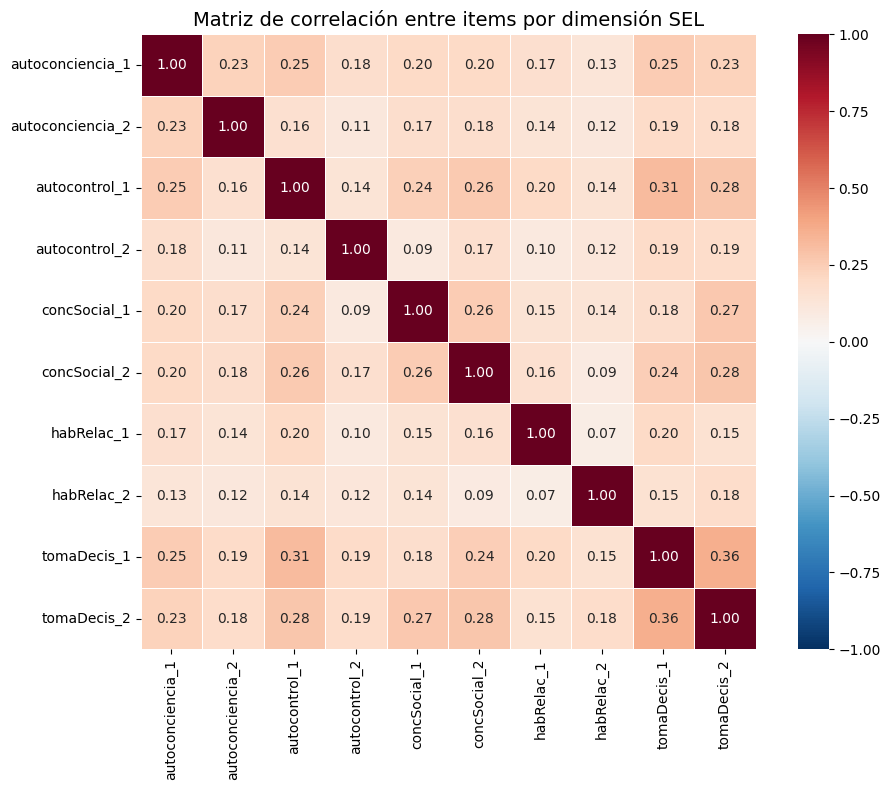

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

items = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8', 'item9', 'item10']

item_labels = {
    'item1': 'autoconciencia_1', 'item2': 'autoconciencia_2',
    'item3': 'autocontrol_1', 'item4': 'autocontrol_2',
    'item5': 'concSocial_1', 'item6': 'concSocial_2',
    'item7': 'habRelac_1', 'item8': 'habRelac_2',
    'item9': 'tomaDecis_1', 'item10': 'tomaDecis_2',
}

corr = df_estudiantes_backup[items].corr()
corr.index = [item_labels[i] for i in corr.index]
corr.columns = [item_labels[i] for i in corr.columns]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Matriz de correlación entre items por dimensión SEL', fontsize=14)
plt.tight_layout()
plt.show()

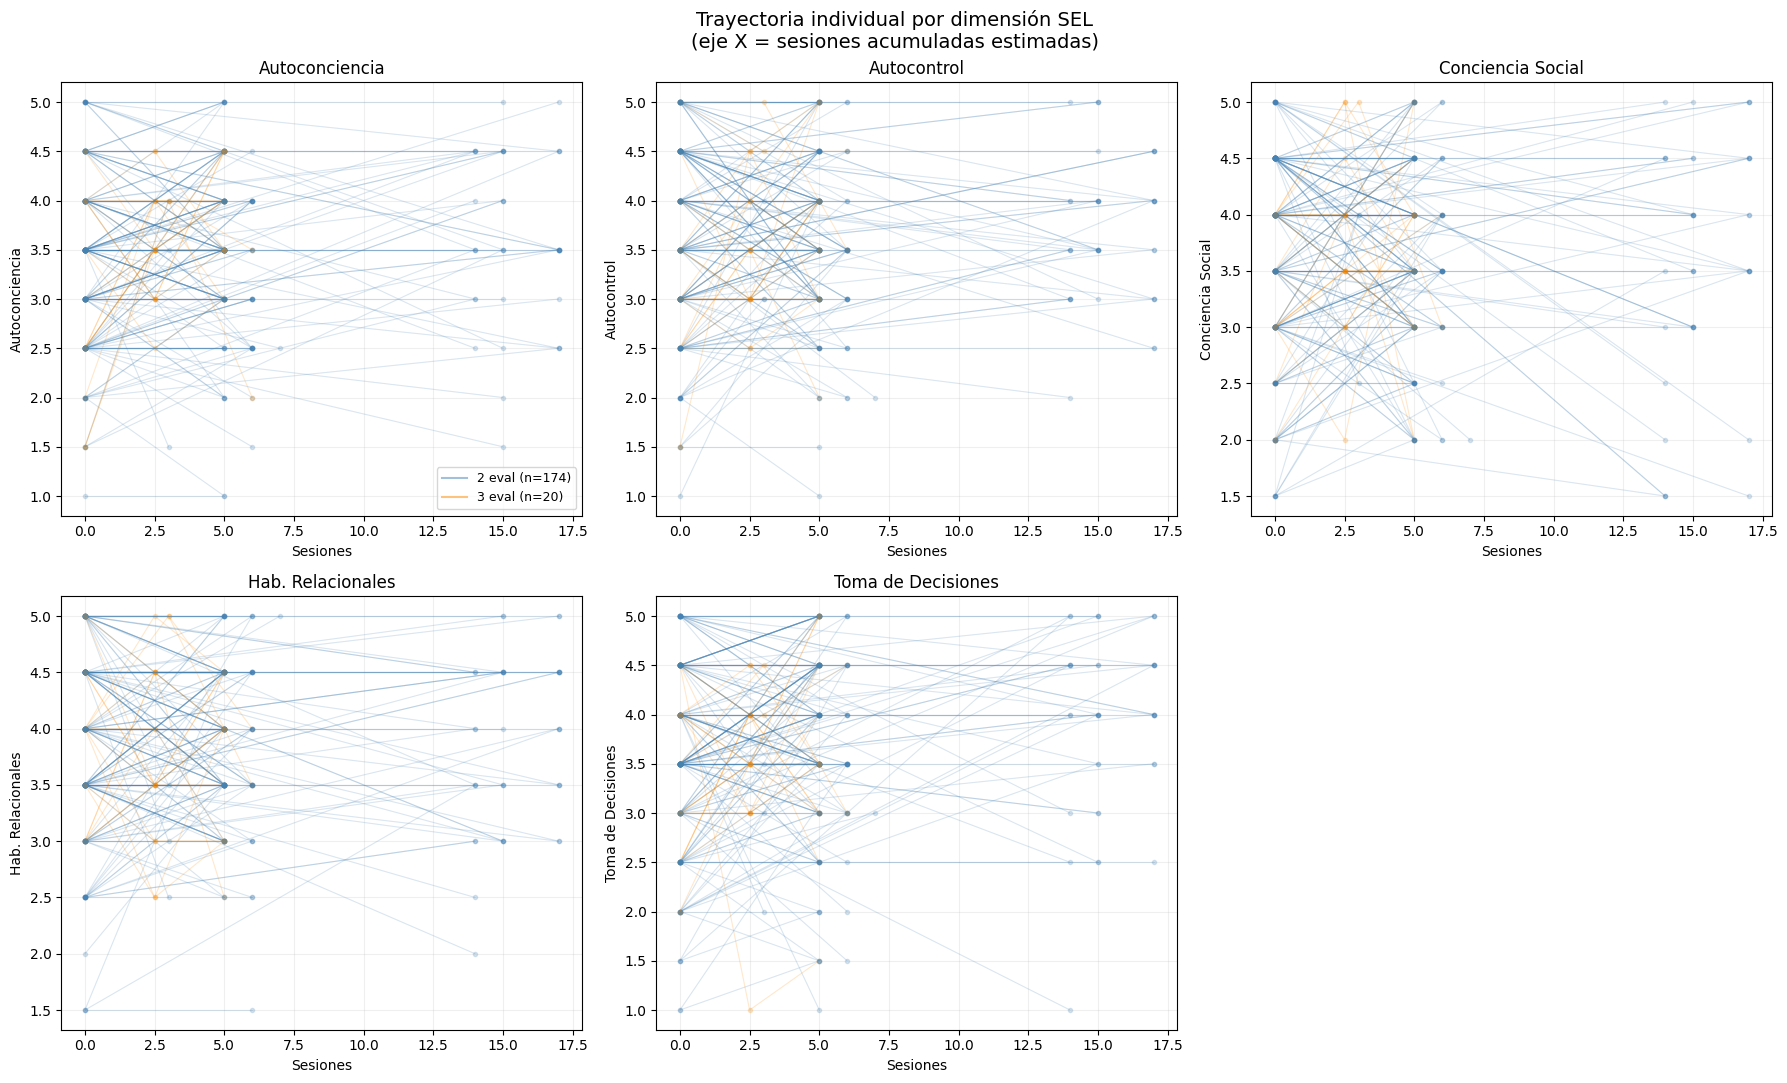

Estudiantes con 2 eval: 174
Estudiantes con 3 eval: 20


In [72]:
import matplotlib.pyplot as plt

dims_cal = ['cal_autoconciencia', 'cal_autocontrol', 'cal_concienciaSocial', 
            'cal_habilidadesRelacionales', 'cal_tomaDeDecisionesResponsables']
labels = ['Autoconciencia', 'Autocontrol', 'Conciencia Social', 'Hab. Relacionales', 'Toma de Decisiones']

df_estudiantes_backup = df_estudiantes_backup.sort_values(['apellidosYNombres', 'fechaDeAplicacion'])
df_estudiantes_backup['num_eval'] = df_estudiantes_backup.groupby('apellidosYNombres').cumcount() + 1

# Estudiantes con 2+ evaluaciones
counts = df_estudiantes_backup.groupby('apellidosYNombres')['num_eval'].max()
est_2plus = counts[counts >= 2].index
df_2plus = df_estudiantes_backup[df_estudiantes_backup['apellidosYNombres'].isin(est_2plus)].copy()

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

for i, (dim, label) in enumerate(zip(dims_cal, labels)):
    ax = axes[i]
    
    for nombre in est_2plus:
        datos = df_2plus[df_2plus['apellidosYNombres'] == nombre].sort_values('num_eval')
        n_evals = len(datos)
        total_ses = datos['sesionesEstudianteEjecutadas'].values[0]
        
        if n_evals == 2:
            x = [0, total_ses]
            y = datos[dim].values[:2]
            color = 'steelblue'
        else:
            x = [0, total_ses / 2, total_ses]
            y = datos[dim].values[:3]
            color = 'darkorange'
        
        ax.plot(x, y, alpha=0.2, color=color, linewidth=0.8, marker='o', markersize=3)
    
    ax.set_xlabel('Sesiones')
    ax.set_ylabel(label)
    ax.set_title(f'{label}')
    ax.grid(True, alpha=0.2)

# Leyenda manual
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='steelblue', alpha=0.5, label=f'2 eval (n={len(est_2plus)-len(est_3eval)})'),
                   Line2D([0], [0], color='darkorange', alpha=0.5, label=f'3 eval (n={len(est_3eval)})')]
axes[0].legend(handles=legend_elements, fontsize=9)

axes[5].set_visible(False)
plt.suptitle('Trayectoria individual por dimensión SEL\n(eje X = sesiones acumuladas estimadas)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Estudiantes con 2 eval: {len(est_2plus)-len(est_3eval)}")
print(f"Estudiantes con 3 eval: {len(est_3eval)}")

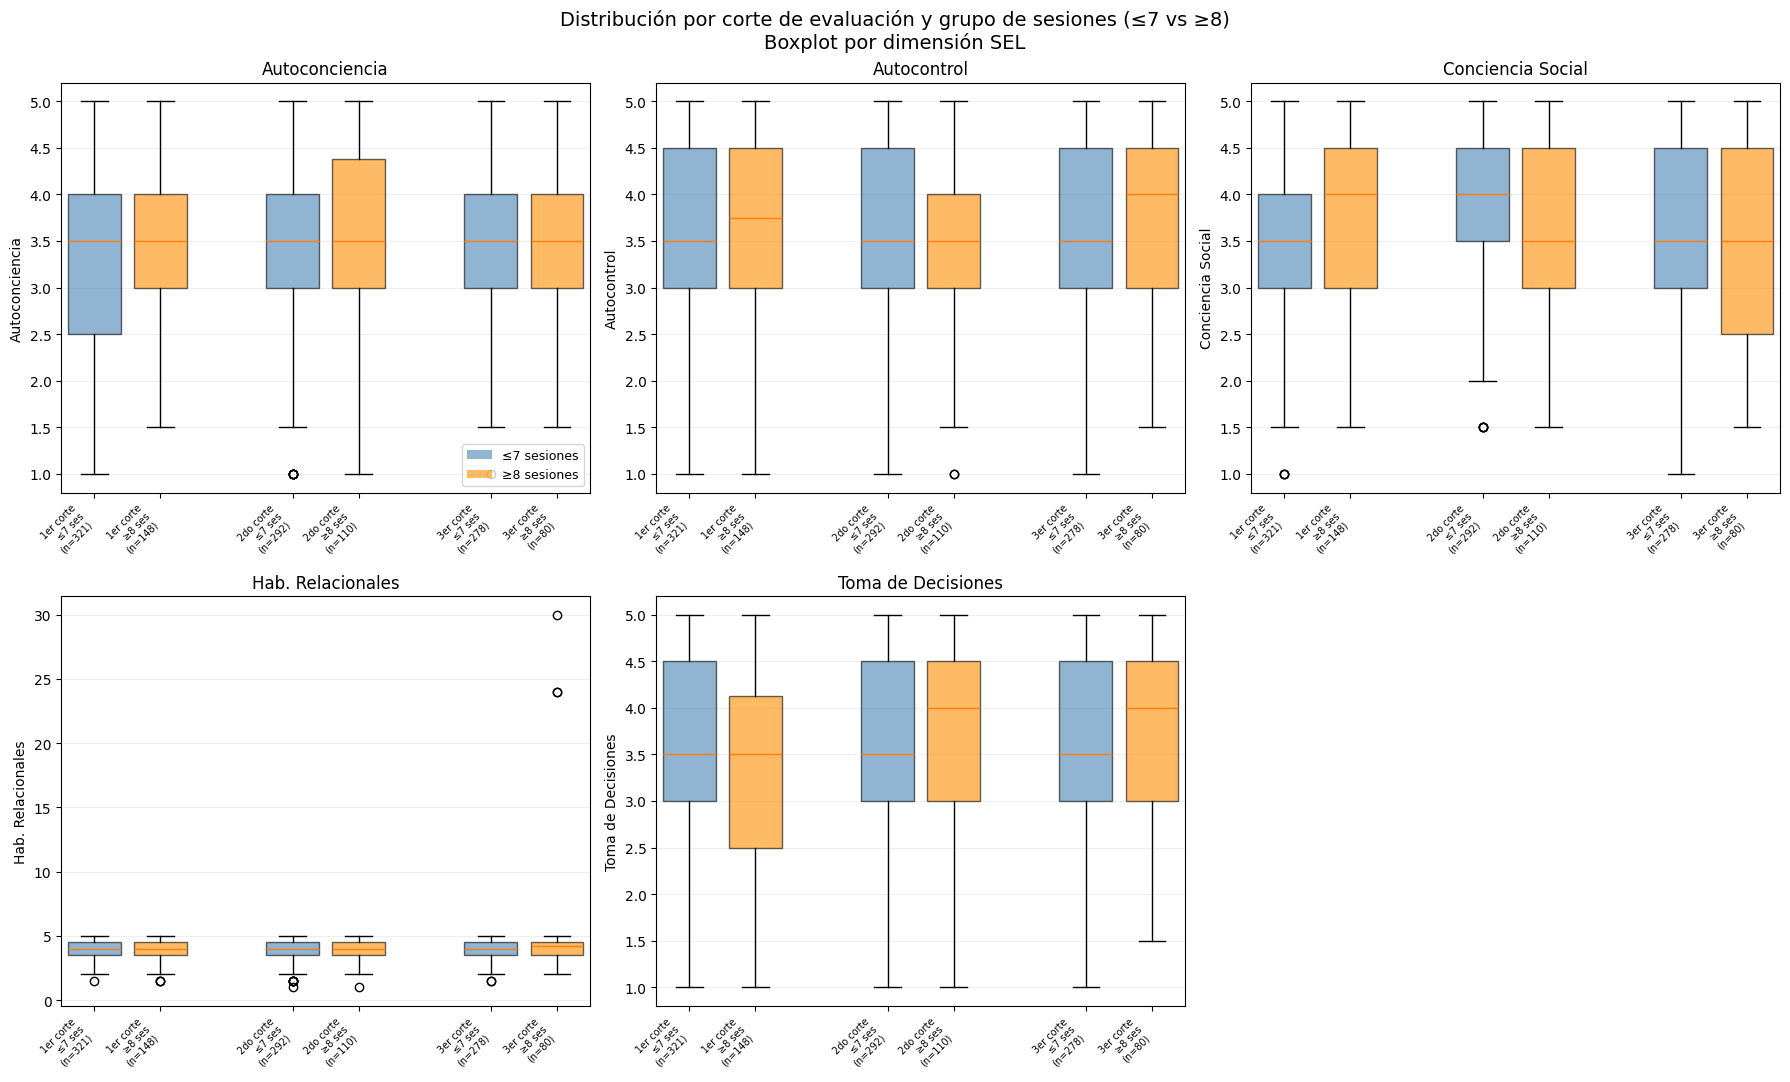

grupo_ses          ≤7 ses  ≥8 ses
corteDeEvaluacion                
1er corte             321     148
2do corte             292     110
3er corte             278      80


In [74]:
import matplotlib.pyplot as plt
import numpy as np

dims_cal = ['cal_autoconciencia', 'cal_autocontrol', 'cal_concienciaSocial', 
            'cal_habilidadesRelacionales', 'cal_tomaDeDecisionesResponsables']
labels = ['Autoconciencia', 'Autocontrol', 'Conciencia Social', 'Hab. Relacionales', 'Toma de Decisiones']

# Grupo de sesiones
df_estudiantes_backup['grupo_ses'] = np.where(df_estudiantes_backup['sesionesEstudianteEjecutadas'] <= 7, '≤7 ses', '≥8 ses')

# Cortes ordenados
cortes = sorted(df_estudiantes_backup['corteDeEvaluacion'].unique())

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

for i, (dim, label) in enumerate(zip(dims_cal, labels)):
    ax = axes[i]
    
    data_to_plot = []
    positions = []
    colors_box = []
    tick_labels = []
    
    for j, corte in enumerate(cortes):
        for k, (grupo, color) in enumerate([('≤7 ses', 'steelblue'), ('≥8 ses', 'darkorange')]):
            subset = df_estudiantes_backup[(df_estudiantes_backup['corteDeEvaluacion'] == corte) & 
                                           (df_estudiantes_backup['grupo_ses'] == grupo)][dim].dropna()
            if len(subset) > 0:
                data_to_plot.append(subset.values)
                positions.append(j * 3 + k)
                colors_box.append(color)
                tick_labels.append(f'{corte}\n{grupo}\n(n={len(subset)})')
    
    bp = ax.boxplot(data_to_plot, positions=positions, widths=0.8, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(tick_labels, fontsize=7, rotation=45, ha='right')
    ax.set_ylabel(label)
    ax.set_title(f'{label}')
    ax.grid(True, alpha=0.2, axis='y')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', alpha=0.6, label='≤7 sesiones'),
                   Patch(facecolor='darkorange', alpha=0.6, label='≥8 sesiones')]
axes[0].legend(handles=legend_elements, fontsize=9)

axes[5].set_visible(False)
plt.suptitle('Distribución por corte de evaluación y grupo de sesiones (≤7 vs ≥8)\nBoxplot por dimensión SEL', fontsize=14)
plt.tight_layout()
plt.show()

# Resumen de conteo
print(df_estudiantes_backup.groupby(['corteDeEvaluacion', 'grupo_ses']).size().unstack(fill_value=0))

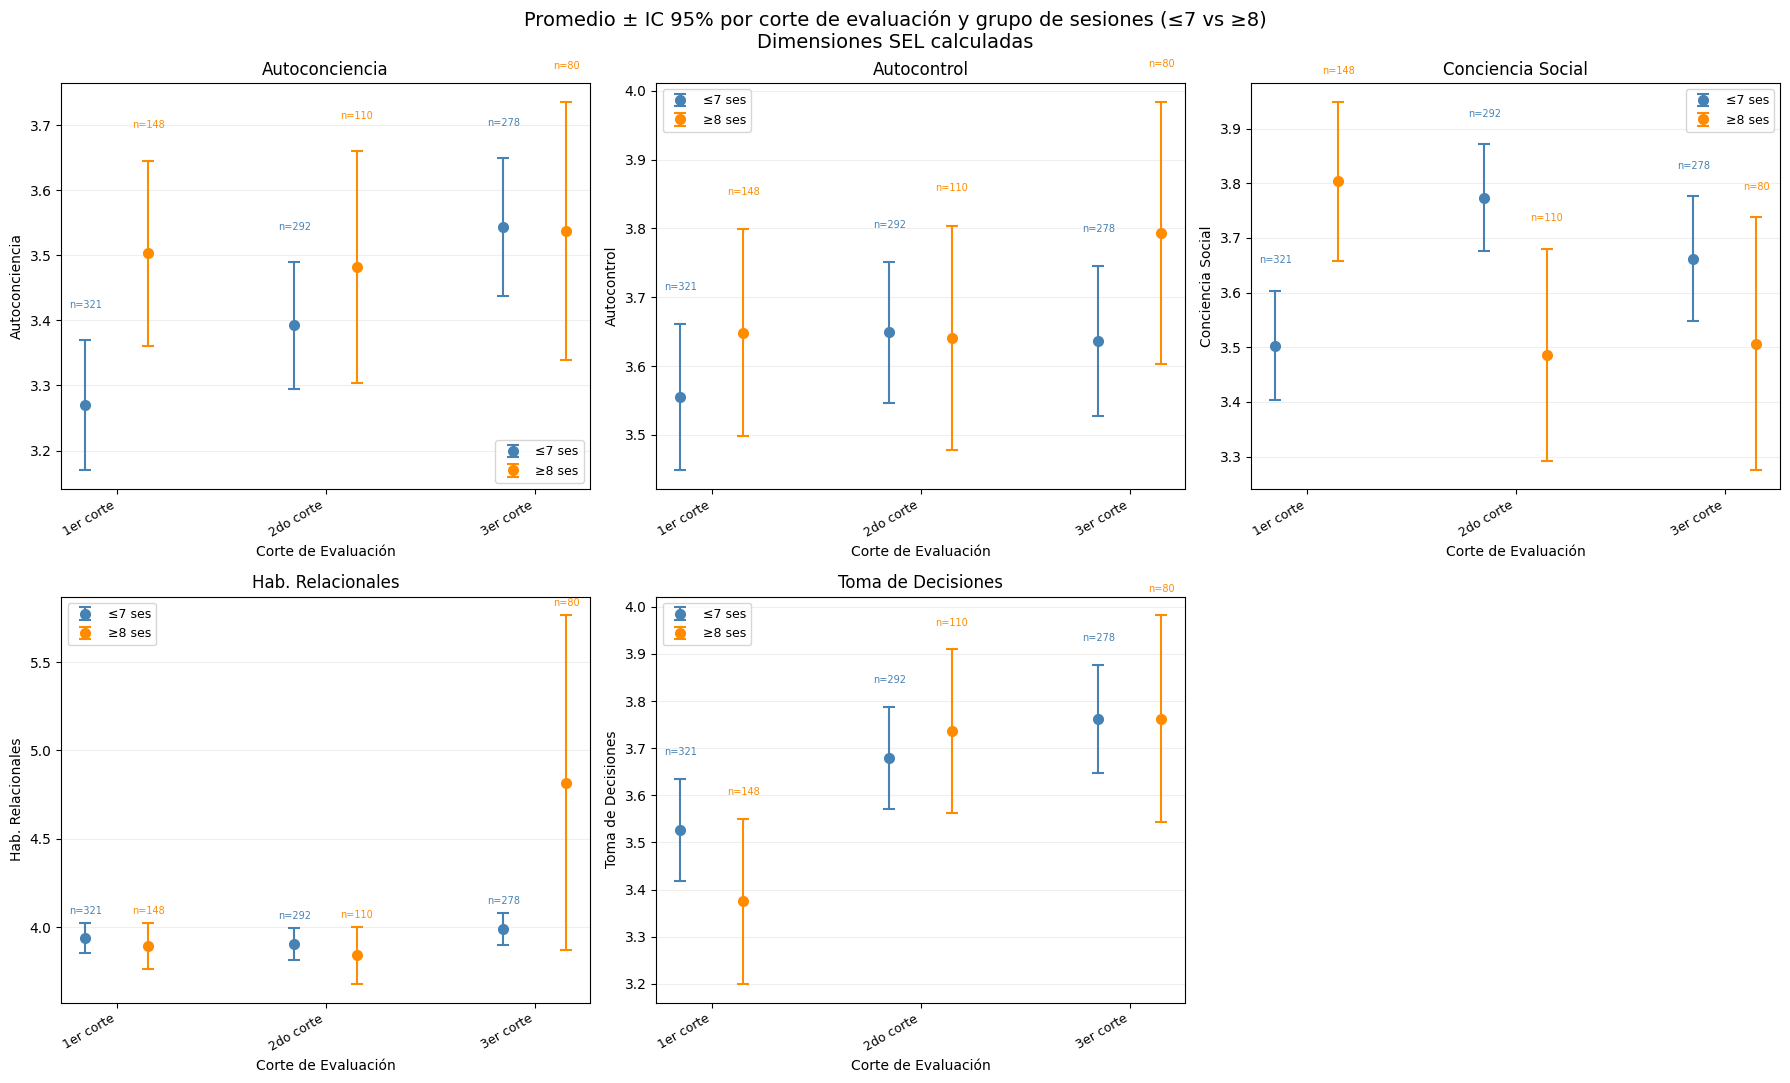

In [75]:
import matplotlib.pyplot as plt
import numpy as np

dims_cal = ['cal_autoconciencia', 'cal_autocontrol', 'cal_concienciaSocial', 
            'cal_habilidadesRelacionales', 'cal_tomaDeDecisionesResponsables']
labels = ['Autoconciencia', 'Autocontrol', 'Conciencia Social', 'Hab. Relacionales', 'Toma de Decisiones']

df_estudiantes_backup['grupo_ses'] = np.where(df_estudiantes_backup['sesionesEstudianteEjecutadas'] <= 7, '≤7 ses', '≥8 ses')
cortes = sorted(df_estudiantes_backup['corteDeEvaluacion'].unique())

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

for i, (dim, label) in enumerate(zip(dims_cal, labels)):
    ax = axes[i]
    
    for k, (grupo, color, offset) in enumerate([('≤7 ses', 'steelblue', -0.15), ('≥8 ses', 'darkorange', 0.15)]):
        means = []
        ci = []
        pos = []
        ns = []
        
        for j, corte in enumerate(cortes):
            subset = df_estudiantes_backup[(df_estudiantes_backup['corteDeEvaluacion'] == corte) & 
                                           (df_estudiantes_backup['grupo_ses'] == grupo)][dim].dropna()
            if len(subset) > 0:
                m = subset.mean()
                se = subset.std() / np.sqrt(len(subset))
                means.append(m)
                ci.append(1.96 * se)
                pos.append(j + offset)
                ns.append(len(subset))
        
        ax.errorbar(pos, means, yerr=ci, fmt='o', color=color, capsize=4, capthick=1.5, 
                    markersize=7, linewidth=1.5, label=grupo)
        
        for p, m, n in zip(pos, means, ns):
            ax.text(p, m + ci[pos.index(p)] + 0.05, f'n={n}', ha='center', fontsize=7, color=color)
    
    ax.set_xticks(range(len(cortes)))
    ax.set_xticklabels(cortes, rotation=30, ha='right', fontsize=9)
    ax.set_xlabel('Corte de Evaluación')
    ax.set_ylabel(label)
    ax.set_title(f'{label}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.2, axis='y')

axes[5].set_visible(False)
plt.suptitle('Promedio ± IC 95% por corte de evaluación y grupo de sesiones (≤7 vs ≥8)\nDimensiones SEL calculadas', fontsize=14)
plt.tight_layout()
plt.show()

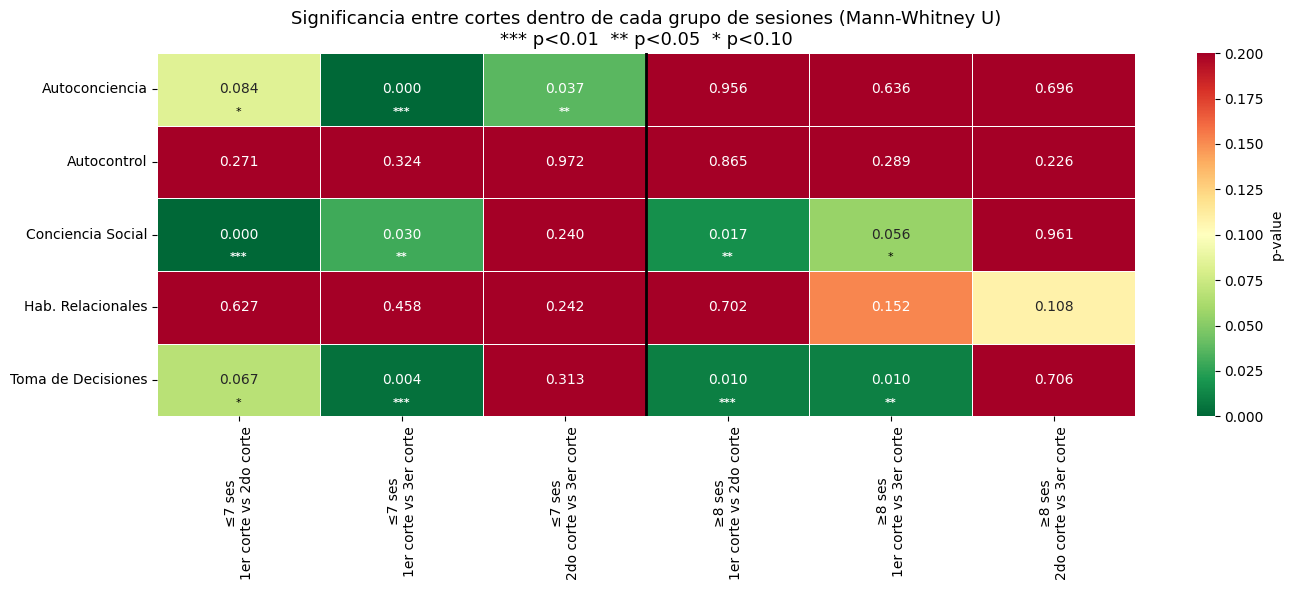

                    ≤7 ses\n1er corte vs 2do corte  \
Autoconciencia                              0.0843   
Autocontrol                                 0.2714   
Conciencia Social                           0.0003   
Hab. Relacionales                           0.6275   
Toma de Decisiones                          0.0672   

                    ≤7 ses\n1er corte vs 3er corte  \
Autoconciencia                              0.0003   
Autocontrol                                 0.3242   
Conciencia Social                           0.0304   
Hab. Relacionales                           0.4582   
Toma de Decisiones                          0.0043   

                    ≤7 ses\n2do corte vs 3er corte  \
Autoconciencia                              0.0370   
Autocontrol                                 0.9716   
Conciencia Social                           0.2397   
Hab. Relacionales                           0.2420   
Toma de Decisiones                          0.3128   

                    ≥8 se

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

dims_cal = ['cal_autoconciencia', 'cal_autocontrol', 'cal_concienciaSocial', 
            'cal_habilidadesRelacionales', 'cal_tomaDeDecisionesResponsables']
labels = ['Autoconciencia', 'Autocontrol', 'Conciencia Social', 'Hab. Relacionales', 'Toma de Decisiones']

df_estudiantes_backup['grupo_ses'] = np.where(df_estudiantes_backup['sesionesEstudianteEjecutadas'] <= 7, '≤7 ses', '≥8 ses')
cortes = sorted(df_estudiantes_backup['corteDeEvaluacion'].unique())

# Comparaciones entre cortes
pares_cortes = [(cortes[0], cortes[1]), (cortes[0], cortes[2]), (cortes[1], cortes[2])]
grupos = ['≤7 ses', '≥8 ses']

comparaciones = []
for grupo in grupos:
    for c1, c2 in pares_cortes:
        comparaciones.append(f'{grupo}\n{c1} vs {c2}')

pval_matrix = np.full((len(dims_cal), len(comparaciones)), np.nan)

for i, dim in enumerate(dims_cal):
    col = 0
    for grupo in grupos:
        for c1, c2 in pares_cortes:
            g1 = df_estudiantes_backup[(df_estudiantes_backup['corteDeEvaluacion'] == c1) & 
                                        (df_estudiantes_backup['grupo_ses'] == grupo)][dim].dropna()
            g2 = df_estudiantes_backup[(df_estudiantes_backup['corteDeEvaluacion'] == c2) & 
                                        (df_estudiantes_backup['grupo_ses'] == grupo)][dim].dropna()
            if len(g1) > 1 and len(g2) > 1:
                _, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
                pval_matrix[i, col] = p
            col += 1

df_pval = pd.DataFrame(pval_matrix, index=labels, columns=comparaciones)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df_pval, annot=True, fmt='.3f', cmap='RdYlGn_r', vmin=0, vmax=0.2,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'p-value'})

for ri in range(len(labels)):
    for ci in range(len(comparaciones)):
        val = pval_matrix[ri, ci]
        if not np.isnan(val):
            if val < 0.01:
                ax.text(ci + 0.5, ri + 0.85, '***', ha='center', fontsize=8, color='white', fontweight='bold')
            elif val < 0.05:
                ax.text(ci + 0.5, ri + 0.85, '**', ha='center', fontsize=8, color='white', fontweight='bold')
            elif val < 0.10:
                ax.text(ci + 0.5, ri + 0.85, '*', ha='center', fontsize=8, color='black')

# Línea separadora entre grupos
ax.axvline(x=3, color='black', linewidth=2)

ax.set_title('Significancia entre cortes dentro de cada grupo de sesiones (Mann-Whitney U)\n*** p<0.01  ** p<0.05  * p<0.10', fontsize=13)
plt.tight_layout()
plt.show()

print(df_pval.round(4))

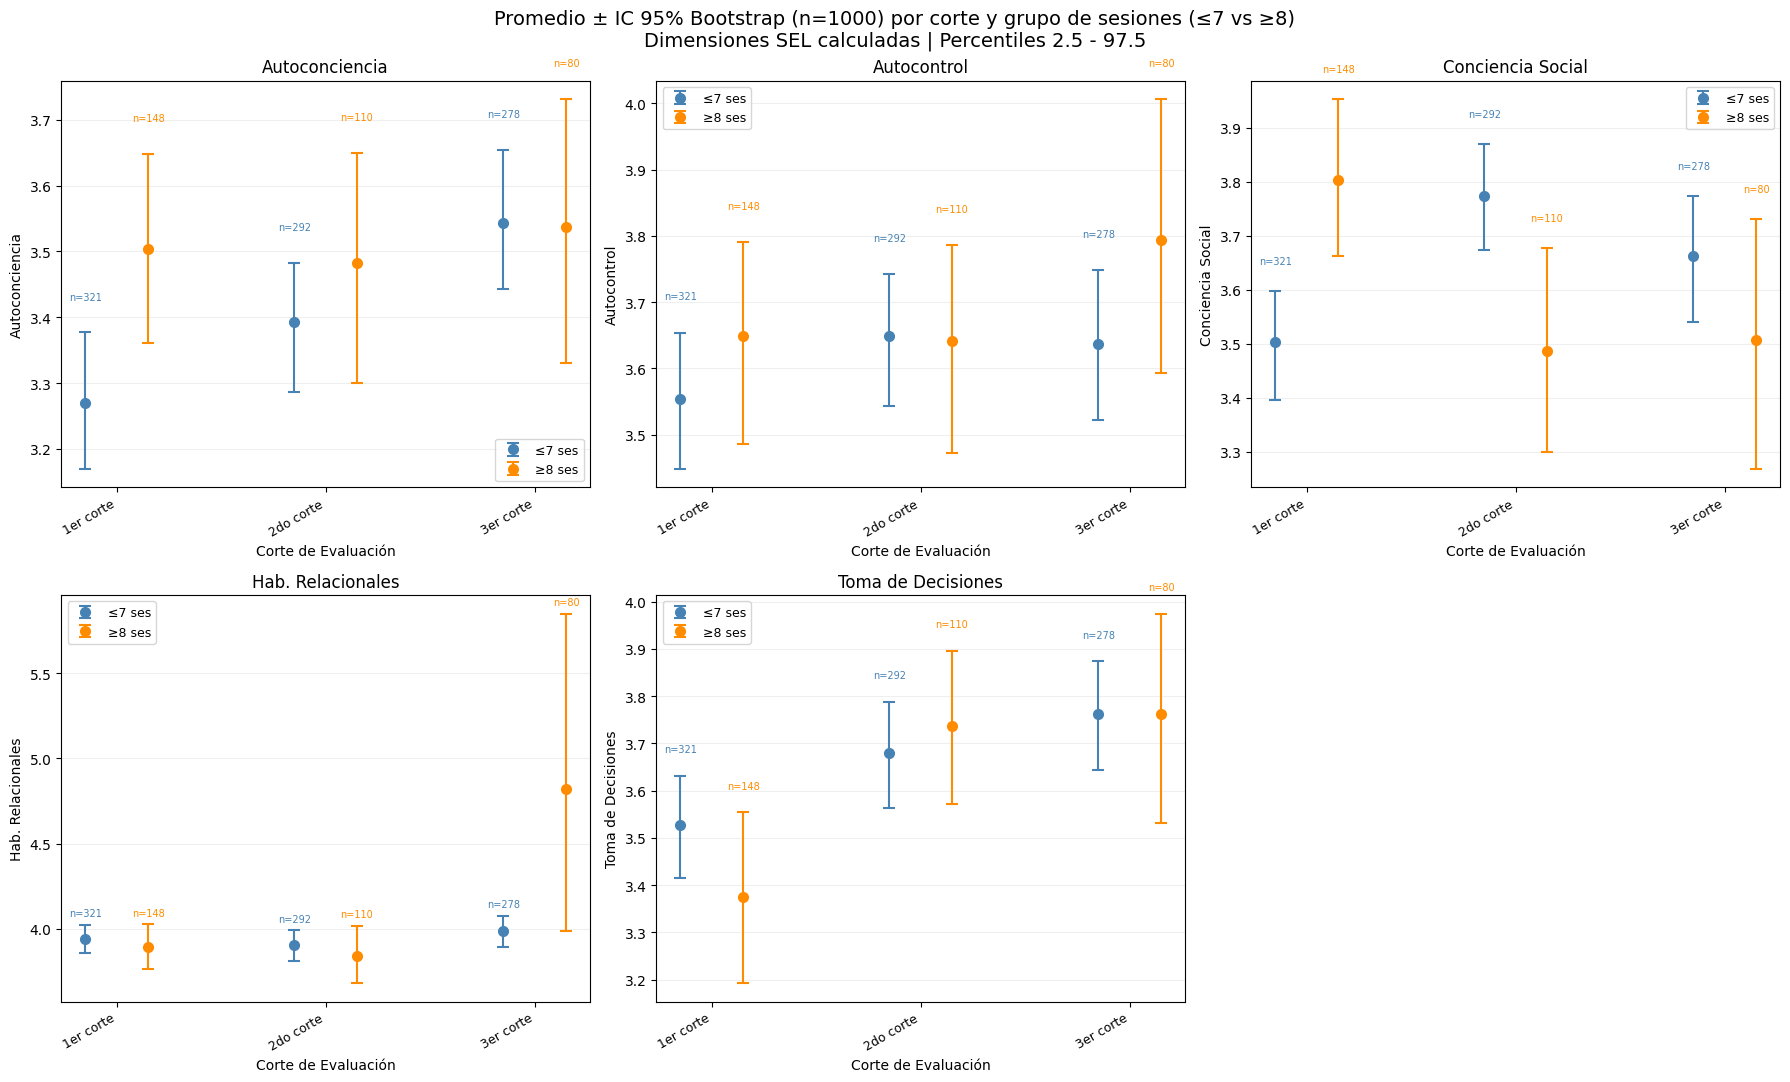

In [76]:
import matplotlib.pyplot as plt
import numpy as np

dims_cal = ['cal_autoconciencia', 'cal_autocontrol', 'cal_concienciaSocial', 
            'cal_habilidadesRelacionales', 'cal_tomaDeDecisionesResponsables']
labels = ['Autoconciencia', 'Autocontrol', 'Conciencia Social', 'Hab. Relacionales', 'Toma de Decisiones']

df_estudiantes_backup['grupo_ses'] = np.where(df_estudiantes_backup['sesionesEstudianteEjecutadas'] <= 7, '≤7 ses', '≥8 ses')
cortes = sorted(df_estudiantes_backup['corteDeEvaluacion'].unique())

np.random.seed(42)
n_boot = 1000

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

for i, (dim, label) in enumerate(zip(dims_cal, labels)):
    ax = axes[i]
    
    for k, (grupo, color, offset) in enumerate([('≤7 ses', 'steelblue', -0.15), ('≥8 ses', 'darkorange', 0.15)]):
        means = []
        err_lo = []
        err_hi = []
        pos = []
        ns = []
        
        for j, corte in enumerate(cortes):
            subset = df_estudiantes_backup[(df_estudiantes_backup['corteDeEvaluacion'] == corte) & 
                                           (df_estudiantes_backup['grupo_ses'] == grupo)][dim].dropna().values
            if len(subset) > 0:
                boot_means = np.array([np.mean(np.random.choice(subset, size=len(subset), replace=True)) 
                                       for _ in range(n_boot)])
                
                m = np.mean(subset)
                ci_lo = np.percentile(boot_means, 2.5)
                ci_hi = np.percentile(boot_means, 97.5)
                
                means.append(m)
                err_lo.append(m - ci_lo)
                err_hi.append(ci_hi - m)
                pos.append(j + offset)
                ns.append(len(subset))
        
        ax.errorbar(pos, means, yerr=[err_lo, err_hi], fmt='o', color=color, capsize=4, capthick=1.5,
                    markersize=7, linewidth=1.5, label=grupo)
        
        for p, m, n, eh in zip(pos, means, ns, err_hi):
            ax.text(p, m + eh + 0.05, f'n={n}', ha='center', fontsize=7, color=color)
    
    ax.set_xticks(range(len(cortes)))
    ax.set_xticklabels(cortes, rotation=30, ha='right', fontsize=9)
    ax.set_xlabel('Corte de Evaluación')
    ax.set_ylabel(label)
    ax.set_title(f'{label}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.2, axis='y')

axes[5].set_visible(False)
plt.suptitle('Promedio ± IC 95% Bootstrap (n=1000) por corte y grupo de sesiones (≤7 vs ≥8)\nDimensiones SEL calculadas | Percentiles 2.5 - 97.5', fontsize=14)
plt.tight_layout()
plt.show()

In [69]:
dim_items = {
    'autoconciencia': ['item1', 'item2'],
    'autocontrol': ['item3', 'item4'],
    'concienciaSocial': ['item5', 'item6'],
    'habilidadesRelacionales': ['item7', 'item8'],
    'tomaDeDecisionesResponsables': ['item9', 'item10'],
}

for dim, cols in dim_items.items():
    df_estudiantes_backup[f'cal_{dim}'] = df_estudiantes_backup[cols].mean(axis=1)

df_estudiantes_backup[[c for c in df_estudiantes_backup.columns if c.startswith('cal_')]].head()

,cal_autoconciencia,cal_autocontrol,cal_concienciaSocial,cal_habilidadesRelacionales,cal_tomaDeDecisionesResponsables
0,2.0,2.0,4.0,3.5,2.0
1,2.5,5.0,3.5,3.0,3.5
2,3.0,4.0,3.0,3.5,2.5
3,2.5,3.0,5.0,3.5,2.0
4,3.0,4.5,3.5,4.0,4.5


### Estudiantes con más de dos evaluaciones

In [31]:
# Mantener solo estudiantes con más de 1 evaluación
conteo = df_estudiantes_clean.groupby('apellidosYNombres')['corteDeEvaluacion'].nunique()
con_mas_de_1 = conteo[conteo > 1].index
df_estudiantes_clean = df_estudiantes_clean[df_estudiantes_clean['apellidosYNombres'].isin(con_mas_de_1)]
print(f"Estudiantes con más de 1 evaluación: {df_estudiantes_clean['apellidosYNombres'].nunique()}")
print(f"Total filas: {len(df_estudiantes_clean)}")

Estudiantes con más de 1 evaluación: 194
Total filas: 408


In [32]:
conteo = df_estudiantes_clean.groupby('apellidosYNombres')['corteDeEvaluacion'].nunique()
print(conteo.value_counts().sort_index().to_string())

corteDeEvaluacion
2    174
3     20


### Mapeo de Dimensiones


In [33]:
mapeo = {'Desarrollado': 3, 'Emergente': 1, 'En proceso': 2}
dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']

for col in dims:
    df_estudiantes_clean[col] = df_estudiantes_clean[col].map(mapeo)

df_estudiantes_clean[dims].head()

,autoconciencia,autocontrol,concienciaSocial,habilidadesRelacionales,tomaDeDecisionesResponsables
1,1,3,2,2,2
2,2,3,2,2,1
3,1,2,3,2,1
4,2,3,2,3,3
5,1,1,3,3,2


In [34]:
# Ordenar por nombre y fecha
df_estudiantes_clean = df_estudiantes_clean.sort_values(['apellidosYNombres', 'fechaDeAplicacion'])

dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']
items = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8', 'item9', 'item10']

# Primera y última evaluación por estudiante
primera = df_estudiantes_clean.groupby('apellidosYNombres').first().reset_index()
ultima = df_estudiantes_clean.groupby('apellidosYNombres').last().reset_index()

# Asignar código único
codigos = {nombre: f'EST_{str(i+1).zfill(4)}' for i, nombre in enumerate(primera['apellidosYNombres'])}
df_estudiantes_clean['codEstudiante'] = df_estudiantes_clean['apellidosYNombres'].map(codigos)

# Construir df comparativo
df_eval = pd.DataFrame({
    'codEstudiante': primera['apellidosYNombres'].map(codigos).values,
    'apellidosYNombres': primera['apellidosYNombres'].values,
    'codModular': primera['codModular'].values,
    'nivelModular': primera['nivelModular'].values,
    'facilitador/a': primera['facilitador/a'].values,
    'fechaPrimera': primera['fechaDeAplicacion'].values,
    'cortePrimera': primera['corteDeEvaluacion'].values,
    **{f'{d}_pre': primera[d].values for d in dims},
    **{f'{it}_pre': primera[it].values for it in items},
    'fechaUltima': ultima['fechaDeAplicacion'].values,
    'corteUltima': ultima['corteDeEvaluacion'].values,
    **{f'{d}_post': ultima[d].values for d in dims},
    **{f'{it}_post': ultima[it].values for it in items},
    **{f'{d}_diff': ultima[d].values - primera[d].values for d in dims},
})

df_eval.head()

,codEstudiante,apellidosYNombres,codModular,nivelModular,facilitador/a,fechaPrimera,cortePrimera,autoconciencia_pre,autocontrol_pre,concienciaSocial_pre,...,item6_post,item7_post,item8_post,item9_post,item10_post,autoconciencia_diff,autocontrol_diff,concienciaSocial_diff,habilidadesRelacionales_diff,tomaDeDecisionesResponsables_diff
0,EST_0001,ALDAVE JESUS ALEXIS,735720,Primaria,Yhon Farfan Pacheco,2025-07-08,1er corte,2,3,3,...,5.0,5.0,4.0,3.0,3.0,0,0,0,0,0
1,EST_0002,ALLAUCA CADENAS GIAMPIER WILLIAM,597609,Secundaria,Yhon Farfan Pacheco,2025-08-11,1er corte,2,1,3,...,4.0,3.0,4.0,3.0,4.0,0,1,-1,0,0
2,EST_0003,Abarca Alhuay Dayiro,577270,Secundaria,Carmen Rosa Delgado Ciriaco,2025-07-22,1er corte,1,1,1,...,3.0,3.0,4.0,4.0,5.0,0,1,1,0,1
3,EST_0004,Alexa Garay Ramirez,542662,Primaria,Jorge Luis Machaca Atamasi,2025-08-12,1er corte,3,1,2,...,4.0,5.0,3.0,4.0,4.0,0,0,0,0,0
4,EST_0005,Alim Laguna,542662,Primaria,Jorge Luis Machaca Atamasi,2025-11-01,2do corte,2,2,3,...,4.0,3.0,4.0,5.0,5.0,0,1,-1,1,1


In [36]:
df_eval.columns

Index(['codEstudiante', 'apellidosYNombres', 'codModular', 'nivelModular',
       'facilitador/a', 'fechaPrimera', 'cortePrimera', 'autoconciencia_pre',
       'autocontrol_pre', 'concienciaSocial_pre',
       'habilidadesRelacionales_pre', 'tomaDeDecisionesResponsables_pre',
       'item1_pre', 'item2_pre', 'item3_pre', 'item4_pre', 'item5_pre',
       'item6_pre', 'item7_pre', 'item8_pre', 'item9_pre', 'item10_pre',
       'fechaUltima', 'corteUltima', 'autoconciencia_post', 'autocontrol_post',
       'concienciaSocial_post', 'habilidadesRelacionales_post',
       'tomaDeDecisionesResponsables_post', 'item1_post', 'item2_post',
       'item3_post', 'item4_post', 'item5_post', 'item6_post', 'item7_post',
       'item8_post', 'item9_post', 'item10_post', 'autoconciencia_diff',
       'autocontrol_diff', 'concienciaSocial_diff',
       'habilidadesRelacionales_diff', 'tomaDeDecisionesResponsables_diff'],
      dtype='object')

In [ ]:
#df_eval.to_excel('df_eval.xlsx', index=False)
#print("Exportado: df_eval.xlsx")

Exportado: df_eval.xlsx


In [40]:
dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']
items = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8', 'item9', 'item10']
all_cols = dims + items

meta = ['codEstudiante', 'codModular', 'apellidosYNombres','nivelModular','facilitador/a']
    
pre = df_eval[meta + ['fechaPrimera', 'cortePrimera'] + [f'{c}_pre' for c in all_cols]].copy()
pre.columns = meta + ['fechaDeAplicacion', 'corteDeEvaluacion'] + all_cols
pre['evaluacion'] = 'pre'

post = df_eval[meta + ['fechaUltima', 'corteUltima'] + [f'{c}_post' for c in all_cols]].copy()
post.columns = meta + ['fechaDeAplicacion', 'corteDeEvaluacion'] + all_cols
post['evaluacion'] = 'post'

df_eval_long = pd.concat([pre, post]).sort_values(['codEstudiante', 'evaluacion']).reset_index(drop=True)
df_eval_long.to_excel('df_eval_long.xlsx', index=False)
print(f"Filas: {len(df_eval_long)} | Columnas: {len(df_eval_long.columns)}")
print(list(df_eval_long.columns))
df_eval_long.head(6)

Filas: 388 | Columnas: 23
['codEstudiante', 'codModular', 'apellidosYNombres', 'nivelModular', 'facilitador/a', 'fechaDeAplicacion', 'corteDeEvaluacion', 'autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8', 'item9', 'item10', 'evaluacion']


,codEstudiante,codModular,apellidosYNombres,nivelModular,facilitador/a,fechaDeAplicacion,corteDeEvaluacion,autoconciencia,autocontrol,concienciaSocial,...,item2,item3,item4,item5,item6,item7,item8,item9,item10,evaluacion
0,EST_0001,735720,ALDAVE JESUS ALEXIS,Primaria,Yhon Farfan Pacheco,2025-11-04,3er corte,2,3,3,...,3.0,5.0,5.0,3.0,5.0,5.0,4.0,3.0,3.0,post
1,EST_0001,735720,ALDAVE JESUS ALEXIS,Primaria,Yhon Farfan Pacheco,2025-07-08,1er corte,2,3,3,...,3.0,5.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,pre
2,EST_0002,597609,ALLAUCA CADENAS GIAMPIER WILLIAM,Secundaria,Yhon Farfan Pacheco,2025-10-27,2do corte,2,2,2,...,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,post
3,EST_0002,597609,ALLAUCA CADENAS GIAMPIER WILLIAM,Secundaria,Yhon Farfan Pacheco,2025-08-11,1er corte,2,1,3,...,3.0,3.0,2.0,4.0,5.0,4.0,3.0,3.0,3.0,pre
4,EST_0003,577270,Abarca Alhuay Dayiro,Secundaria,Carmen Rosa Delgado Ciriaco,2025-10-20,2do corte,1,2,2,...,2.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,5.0,post
5,EST_0003,577270,Abarca Alhuay Dayiro,Secundaria,Carmen Rosa Delgado Ciriaco,2025-07-22,1er corte,1,1,1,...,2.0,3.0,2.0,2.0,1.0,4.0,3.0,3.0,3.0,pre


In [41]:
df_eval_long.columns

Index(['codEstudiante', 'codModular', 'apellidosYNombres', 'nivelModular',
       'facilitador/a', 'fechaDeAplicacion', 'corteDeEvaluacion',
       'autoconciencia', 'autocontrol', 'concienciaSocial',
       'habilidadesRelacionales', 'tomaDeDecisionesResponsables', 'item1',
       'item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8', 'item9',
       'item10', 'evaluacion'],
      dtype='object')

## Calculo de los PCA

### 1,2 autoconciencia
### 3,4 autocontrol
### 5,6 conciencia social
### 7,8 habilidades relacionales
### 9,10 toma de decisiones

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

dim_items = {
    'autoconciencia': ['item1', 'item2'],
    'autocontrol': ['item3', 'item4'],
    'concienciaSocial': ['item5', 'item6'],
    'habilidadesRelacionales': ['item7', 'item8'],
    'tomaDeDecisionesResponsables': ['item9', 'item10'],
}

for dim, cols in dim_items.items():
    print(f"\n{'='*50}")
    print(f"PCA - {dim} ({', '.join(cols)})")
    print('='*50)
    
    X = df_eval_long[cols].dropna()
    X_scaled = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=min(3, len(cols)))
    pca.fit(X_scaled)
    
    print(f"Componentes: {pca.n_components_}")
    print(f"Varianza explicada: {pca.explained_variance_ratio_}")
    print(f"Varianza acumulada: {np.cumsum(pca.explained_variance_ratio_)}")
    print(f"\nLoadings:")
    for i, comp in enumerate(pca.components_):
        print(f"  PC{i+1}: {dict(zip(cols, np.round(comp, 4)))}")


PCA - autoconciencia (item1, item2)
Componentes: 2
Varianza explicada: [0.59632461 0.40367539]
Varianza acumulada: [0.59632461 1.        ]

Loadings:
  PC1: {'item1': np.float64(0.7071), 'item2': np.float64(0.7071)}
  PC2: {'item1': np.float64(0.7071), 'item2': np.float64(-0.7071)}

PCA - autocontrol (item3, item4)
Componentes: 2
Varianza explicada: [0.56686272 0.43313728]
Varianza acumulada: [0.56686272 1.        ]

Loadings:
  PC1: {'item3': np.float64(0.7071), 'item4': np.float64(0.7071)}
  PC2: {'item3': np.float64(-0.7071), 'item4': np.float64(0.7071)}

PCA - concienciaSocial (item5, item6)
Componentes: 2
Varianza explicada: [0.59749501 0.40250499]
Varianza acumulada: [0.59749501 1.        ]

Loadings:
  PC1: {'item5': np.float64(0.7071), 'item6': np.float64(0.7071)}
  PC2: {'item5': np.float64(-0.7071), 'item6': np.float64(0.7071)}

PCA - habilidadesRelacionales (item7, item8)
Componentes: 2
Varianza explicada: [0.54771363 0.45228637]
Varianza acumulada: [0.54771363 1.        ]


## Calcula los promedios simples

In [43]:
dim_items = {
    'autoconciencia': ['item1', 'item2'],
    'autocontrol': ['item3', 'item4'],
    'concienciaSocial': ['item5', 'item6'],
    'habilidadesRelacionales': ['item7', 'item8'],
    'tomaDeDecisionesResponsables': ['item9', 'item10'],
}

for dim, cols in dim_items.items():
    df_eval_long[f'cal_{dim}'] = df_eval_long[cols].mean(axis=1)

df_eval_long[[c for c in df_eval_long.columns if c.startswith('cal_')]].head(6)

,cal_autoconciencia,cal_autocontrol,cal_concienciaSocial,cal_habilidadesRelacionales,cal_tomaDeDecisionesResponsables
0,3.5,5.0,4.0,4.5,3.0
1,3.5,5.0,4.5,4.0,3.5
2,3.5,3.0,3.5,3.5,3.5
3,3.5,2.5,4.5,3.5,3.0
4,2.5,3.0,3.5,3.5,4.5
5,2.5,2.5,1.5,3.5,3.0


## Calulo de variacion por dimensión calculada

/var/folders/ky/nc_72jhs2jz7s9llnl6mxhdr0000gn/T/ipykernel_42445/3388220736.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dims_orig, rotation=30, ha='right')


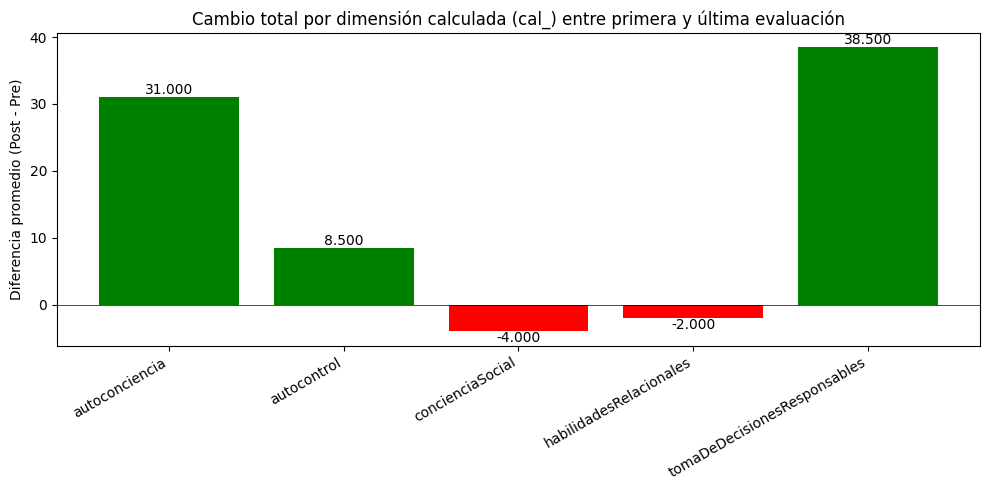

In [44]:
import matplotlib.pyplot as plt

dims_orig = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']
dims_cal = [f'cal_{d}' for d in dims_orig]

pre = df_eval_long[df_eval_long['evaluacion'] == 'pre'][dims_cal].sum()
post = df_eval_long[df_eval_long['evaluacion'] == 'post'][dims_cal].sum()
diff = post - pre

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if d >= 0 else 'red' for d in diff]
bars = ax.bar(dims_orig, diff.values, color=colors)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Diferencia promedio (Post - Pre)')
ax.set_title('Cambio total por dimensión calculada (cal_) entre primera y última evaluación')
ax.set_xticklabels(dims_orig, rotation=30, ha='right')

for bar, val in zip(bars, diff.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.3f}', ha='center', va='bottom' if val >= 0 else 'top')

plt.tight_layout()
plt.show()

In [45]:
dims_cal = ['cal_autoconciencia', 'cal_autocontrol', 'cal_concienciaSocial', 'cal_habilidadesRelacionales', 'cal_tomaDeDecisionesResponsables']
meta = ['codEstudiante', 'codModular', 'apellidosYNombres', 'nivelModular', 'facilitador/a']

pre = df_eval_long[df_eval_long['evaluacion'] == 'pre'].set_index('codEstudiante')
post = df_eval_long[df_eval_long['evaluacion'] == 'post'].set_index('codEstudiante')

df_cal_diff = pre[meta[1:]].copy()
for c in dims_cal:
    df_cal_diff[f'{c}_diff'] = post[c] - pre[c]

df_cal_diff = df_cal_diff.reset_index()
df_cal_diff.head()


,codEstudiante,codModular,apellidosYNombres,nivelModular,facilitador/a,cal_autoconciencia_diff,cal_autocontrol_diff,cal_concienciaSocial_diff,cal_habilidadesRelacionales_diff,cal_tomaDeDecisionesResponsables_diff
0,EST_0001,735720,ALDAVE JESUS ALEXIS,Primaria,Yhon Farfan Pacheco,0.0,0.0,-0.5,0.5,-0.5
1,EST_0002,597609,ALLAUCA CADENAS GIAMPIER WILLIAM,Secundaria,Yhon Farfan Pacheco,0.0,0.5,-1.0,0.0,0.5
2,EST_0003,577270,Abarca Alhuay Dayiro,Secundaria,Carmen Rosa Delgado Ciriaco,0.0,0.5,2.0,0.0,1.5
3,EST_0004,542662,Alexa Garay Ramirez,Primaria,Jorge Luis Machaca Atamasi,0.0,-0.5,0.0,0.0,0.0
4,EST_0005,542662,Alim Laguna,Primaria,Jorge Luis Machaca Atamasi,0.5,1.0,-1.0,1.0,2.0


## Sessiones

In [46]:
df_sesiones = pd.read_excel('Sesiones.xlsx', sheet_name='Hoja1')
df_sesiones = df_sesiones[['Sesiones Estudiante ejecutadas', 'CODIGO MODULAR']]

import re

def to_camel_case(s):
    s = s.strip().lower()
    for a, b in [('á','a'),('é','e'),('í','i'),('ó','o'),('ú','u'),('ñ','n')]:
        s = s.replace(a, b)
    s = re.sub(r'[¿?./,()°]', '', s)
    words = re.split(r'[\s_]+', s)
    return words[0] + ''.join(w.capitalize() for w in words[1:])

df_sesiones.columns = [to_camel_case(c) for c in df_sesiones.columns]
print(df_sesiones.columns.tolist())


['sesionesEstudianteEjecutadas', 'codigoModular']


In [47]:
df_sesiones

,sesionesEstudianteEjecutadas,codigoModular
0,6,411447
1,6,415166
2,6,681478
3,5,247650
4,5,577270
5,6,247668
6,6,1090851
7,5,476531
8,5,343640
9,14,681346


In [48]:
df_eval = df_eval.merge(df_sesiones, left_on='codModular', right_on='codigoModular', how='left').drop(columns='codigoModular')
df_eval.head()

,codEstudiante,apellidosYNombres,codModular,nivelModular,facilitador/a,fechaPrimera,cortePrimera,autoconciencia_pre,autocontrol_pre,concienciaSocial_pre,...,item7_post,item8_post,item9_post,item10_post,autoconciencia_diff,autocontrol_diff,concienciaSocial_diff,habilidadesRelacionales_diff,tomaDeDecisionesResponsables_diff,sesionesEstudianteEjecutadas
0,EST_0001,ALDAVE JESUS ALEXIS,735720,Primaria,Yhon Farfan Pacheco,2025-07-08,1er corte,2,3,3,...,5.0,4.0,3.0,3.0,0,0,0,0,0,15
1,EST_0002,ALLAUCA CADENAS GIAMPIER WILLIAM,597609,Secundaria,Yhon Farfan Pacheco,2025-08-11,1er corte,2,1,3,...,3.0,4.0,3.0,4.0,0,1,-1,0,0,17
2,EST_0003,Abarca Alhuay Dayiro,577270,Secundaria,Carmen Rosa Delgado Ciriaco,2025-07-22,1er corte,1,1,1,...,3.0,4.0,4.0,5.0,0,1,1,0,1,5
3,EST_0004,Alexa Garay Ramirez,542662,Primaria,Jorge Luis Machaca Atamasi,2025-08-12,1er corte,3,1,2,...,5.0,3.0,4.0,4.0,0,0,0,0,0,5
4,EST_0005,Alim Laguna,542662,Primaria,Jorge Luis Machaca Atamasi,2025-11-01,2do corte,2,2,3,...,3.0,4.0,5.0,5.0,0,1,-1,1,1,5


## Con Cal, facilitadores y grados

In [49]:

df_cal_diff = df_cal_diff.merge(df_sesiones, left_on='codModular', right_on='codigoModular', how='left').drop(columns='codigoModular')
df_cal_diff.head()

,codEstudiante,codModular,apellidosYNombres,nivelModular,facilitador/a,cal_autoconciencia_diff,cal_autocontrol_diff,cal_concienciaSocial_diff,cal_habilidadesRelacionales_diff,cal_tomaDeDecisionesResponsables_diff,sesionesEstudianteEjecutadas
0,EST_0001,735720,ALDAVE JESUS ALEXIS,Primaria,Yhon Farfan Pacheco,0.0,0.0,-0.5,0.5,-0.5,15
1,EST_0002,597609,ALLAUCA CADENAS GIAMPIER WILLIAM,Secundaria,Yhon Farfan Pacheco,0.0,0.5,-1.0,0.0,0.5,17
2,EST_0003,577270,Abarca Alhuay Dayiro,Secundaria,Carmen Rosa Delgado Ciriaco,0.0,0.5,2.0,0.0,1.5,5
3,EST_0004,542662,Alexa Garay Ramirez,Primaria,Jorge Luis Machaca Atamasi,0.0,-0.5,0.0,0.0,0.0,5
4,EST_0005,542662,Alim Laguna,Primaria,Jorge Luis Machaca Atamasi,0.5,1.0,-1.0,1.0,2.0,5


In [50]:
df_cal_diff = df_cal_diff.drop(columns=['sesionesEstudianteEjecutadas_x', 'sesionesEstudianteEjecutadas_y'], errors='ignore')
df_cal_diff.columns.tolist()

['codEstudiante',
 'codModular',
 'apellidosYNombres',
 'nivelModular',
 'facilitador/a',
 'cal_autoconciencia_diff',
 'cal_autocontrol_diff',
 'cal_concienciaSocial_diff',
 'cal_habilidadesRelacionales_diff',
 'cal_tomaDeDecisionesResponsables_diff',
 'sesionesEstudianteEjecutadas']

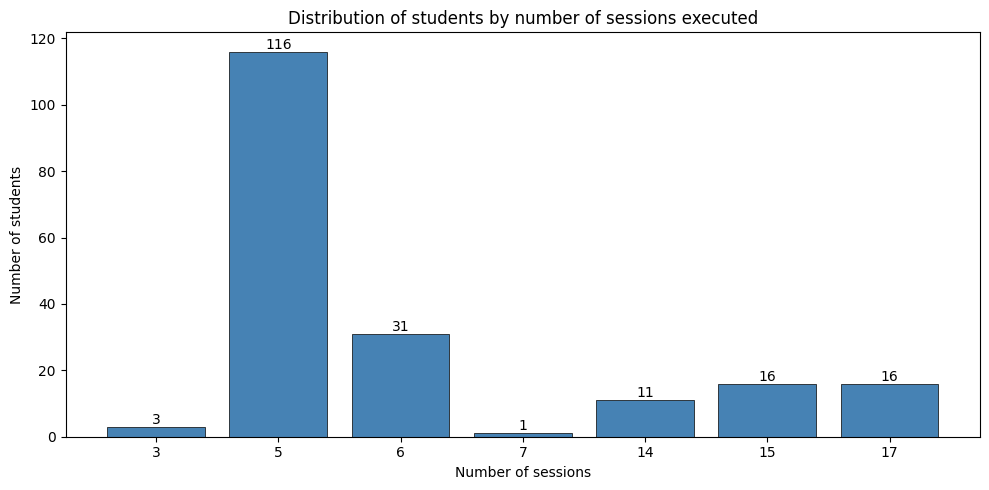

In [51]:
import matplotlib.pyplot as plt

conteo = df_cal_diff['sesionesEstudianteEjecutadas'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(conteo.index.astype(str), conteo.values, color='steelblue', edgecolor='black', linewidth=0.5)

for bar, val in zip(bars, conteo.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(val), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Number of sessions')
ax.set_ylabel('Number of students')
ax.set_title('Distribution of students by number of sessions executed')
plt.tight_layout()
plt.show()

In [52]:
df_cal_diff = df_cal_diff[~df_cal_diff['sesionesEstudianteEjecutadas'].isin([3, 7])].reset_index(drop=True)
print(f"Filas: {len(df_cal_diff)}")

Filas: 190


In [53]:
import statsmodels.formula.api as smf

dims_cal = ['cal_autoconciencia_diff', 'cal_autocontrol_diff', 'cal_concienciaSocial_diff',
            'cal_habilidadesRelacionales_diff', 'cal_tomaDeDecisionesResponsables_diff']

for dep in dims_cal:
    print(f"\n{'='*80}")
    print(f"Y = {dep}")
    print('='*80)
    
    formula = f'Q("{dep}") ~ sesionesEstudianteEjecutadas + I(sesionesEstudianteEjecutadas**2) + C(Q("facilitador/a")) + C(nivelModular)'
    
    model = smf.ols(formula, data=df_cal_diff).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_cal_diff['codModular']}
    )
    
    print(model.summary())


Y = cal_autoconciencia_diff
                                 OLS Regression Results                                 
Dep. Variable:     Q("cal_autoconciencia_diff")   R-squared:                       0.015
Model:                                      OLS   Adj. R-squared:                 -0.023
Method:                           Least Squares   F-statistic:                    0.6756
Date:                          Sun, 22 Feb 2026   Prob (F-statistic):              0.690
Time:                                  13:13:02   Log-Likelihood:                -242.96
No. Observations:                           190   AIC:                             501.9
Df Residuals:                               182   BIC:                             527.9
Df Model:                                     7                                         
Covariance Type:                        cluster                                         
                                                           coef    std err       

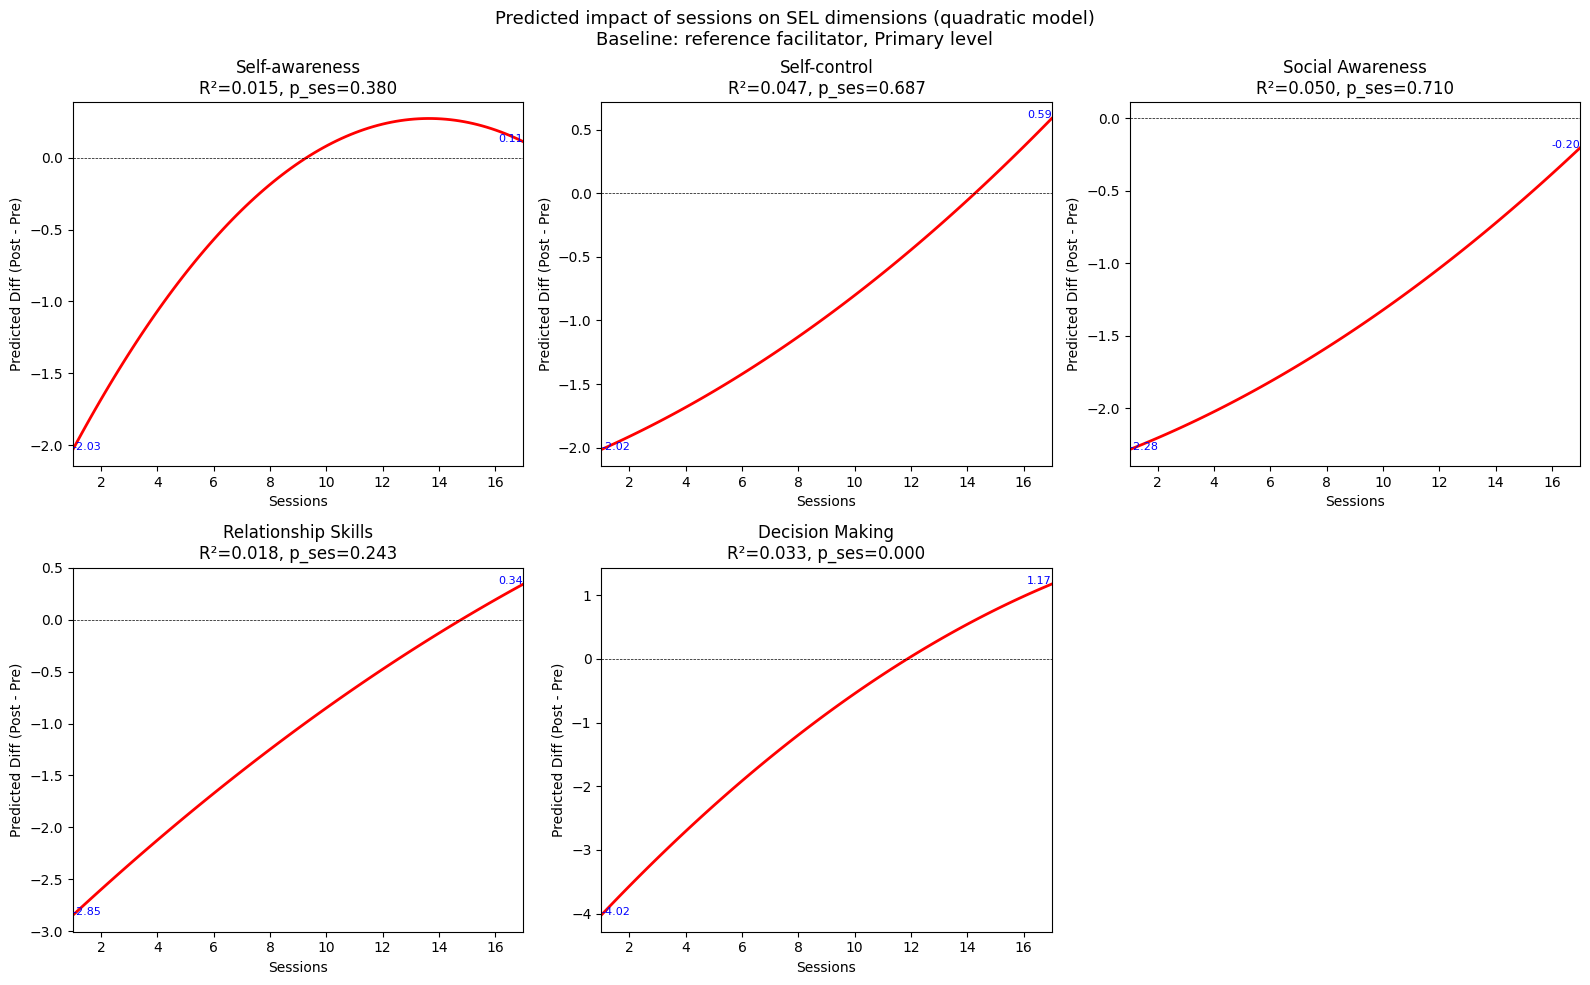

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Coeficientes: (intercepto, b1_sesiones, b2_sesiones²)
coefs = {
    'Self-awareness':      (-2.4099, 0.3931, -0.0144),
    'Self-control':        (-2.1103, 0.0908,  0.0040),
    'Social Awareness':    (-2.3586, 0.0707,  0.0033),
    'Relationship Skills': (-3.0993, 0.2569, -0.0032),
    'Decision Making':     (-4.4985, 0.4833, -0.0088),
}

pvals_lin = [0.380, 0.687, 0.710, 0.243, 0.000]
r2 = [0.015, 0.047, 0.050, 0.018, 0.033]

x = np.linspace(1, 17, 100)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, (label, (b0, b1, b2)) in enumerate(coefs.items()):
    y = b0 + b1 * x + b2 * x**2
    
    ax = axes[i]
    ax.plot(x, y, color='red', linewidth=2)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Predicted Diff (Post - Pre)')
    ax.set_title(f'{label}\nR²={r2[i]:.3f}, p_ses={pvals_lin[i]:.3f}')
    ax.set_xlim(1, 17)
    
    # Anotar valores en sesión 1 y 17
    y1 = b0 + b1*1 + b2*1**2
    y17 = b0 + b1*17 + b2*17**2
    ax.annotate(f'{y1:.2f}', (1, y1), fontsize=8, color='blue')
    ax.annotate(f'{y17:.2f}', (17, y17), fontsize=8, color='blue', ha='right')

axes[5].set_visible(False)
plt.suptitle('Predicted impact of sessions on SEL dimensions (quadratic model)\nBaseline: reference facilitator, Primary level', fontsize=13)
plt.tight_layout()
plt.show()



In [55]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

np.random.seed(42)

dims_cal = ['cal_autoconciencia_diff', 'cal_autocontrol_diff', 'cal_concienciaSocial_diff',
            'cal_habilidadesRelacionales_diff', 'cal_tomaDeDecisionesResponsables_diff']
labels = ['Autoconciencia', 'Autocontrol', 'Conciencia Social', 'Hab. Relacionales', 'Toma de Decisiones']

n_boot = 1000
clusters = df_cal_diff['codModular'].unique()
n_clusters = len(clusters)

results = {}

for dep, label in zip(dims_cal, labels):
    print(f"Bootstrapping {label}...", end=' ')
    
    formula = f'Q("{dep}") ~ sesionesEstudianteEjecutadas + I(sesionesEstudianteEjecutadas**2) + C(Q("facilitador/a")) + C(nivelModular)'
    
    boot_b1 = []
    boot_b2 = []
    
    for b in range(n_boot):
        # Block bootstrap: resamplear clusters con reemplazo
        sampled_clusters = np.random.choice(clusters, size=n_clusters, replace=True)
        
        # Construir muestra bootstrap concatenando bloques
        frames = []
        for c in sampled_clusters:
            frames.append(df_cal_diff[df_cal_diff['codModular'] == c])
        df_boot = pd.concat(frames, ignore_index=True)
        
        try:
            model = smf.ols(formula, data=df_boot).fit(disp=0)
            boot_b1.append(model.params['sesionesEstudianteEjecutadas'])
            boot_b2.append(model.params['I(sesionesEstudianteEjecutadas ** 2)'])
        except:
            continue
    
    boot_b1 = np.array(boot_b1)
    boot_b2 = np.array(boot_b2)
    
    # Punto óptimo por iteración
    # Solo calcular óptimo cuando b2 < 0 (tiene máximo)
    boot_xopt = -boot_b1 / (2 * boot_b2)
    boot_yopt = boot_b1 * boot_xopt + boot_b2 * boot_xopt**2
    
    results[label] = {
        'b1': boot_b1, 'b2': boot_b2,
        'x_opt': boot_xopt, 'y_opt': boot_yopt
    }
    
    print(f"OK ({len(boot_b1)} réplicas)")
    print(f"  b1:    {np.mean(boot_b1):.4f} IC95% [{np.percentile(boot_b1, 2.5):.4f}, {np.percentile(boot_b1, 97.5):.4f}]")
    print(f"  b2:    {np.mean(boot_b2):.4f} IC95% [{np.percentile(boot_b2, 2.5):.4f}, {np.percentile(boot_b2, 97.5):.4f}]")
    print(f"  X_opt: {np.median(boot_xopt):.1f}  IC95% [{np.percentile(boot_xopt, 2.5):.1f}, {np.percentile(boot_xopt, 97.5):.1f}]")
    print(f"  Y_opt: {np.median(boot_yopt):.4f} IC95% [{np.percentile(boot_yopt, 2.5):.4f}, {np.percentile(boot_yopt, 97.5):.4f}]")
    print()

Bootstrapping Autoconciencia... OK (1000 réplicas)
  b1:    0.5413 IC95% [-0.7282, 2.1409]
  b2:    -0.0223 IC95% [-0.1070, 0.0360]
  X_opt: 12.4  IC95% [-28.8, 55.4]
  Y_opt: 3.0283 IC95% [-8.2173, 16.2600]

Bootstrapping Autocontrol... OK (1000 réplicas)
  b1:    0.1190 IC95% [-0.7189, 1.2616]
  b2:    0.0003 IC95% [-0.0677, 0.0347]
  X_opt: 9.1  IC95% [-53.0, 89.3]
  Y_opt: -0.1550 IC95% [-6.5767, 18.8650]

Bootstrapping Conciencia Social... OK (1000 réplicas)
  b1:    0.1309 IC95% [-1.3115, 1.3829]
  b2:    -0.0031 IC95% [-0.0561, 0.0481]
  X_opt: 9.0  IC95% [-53.4, 95.5]
  Y_opt: 0.1734 IC95% [-13.0621, 15.1388]

Bootstrapping Hab. Relacionales... OK (1000 réplicas)
  b1:    0.1897 IC95% [-0.6000, 1.1015]
  b2:    -0.0028 IC95% [-0.0512, 0.0308]
  X_opt: 9.1  IC95% [-87.8, 69.9]
  Y_opt: 0.5855 IC95% [-11.0363, 13.3869]

Bootstrapping Toma de Decisiones... OK (1000 réplicas)
  b1:    0.4316 IC95% [-0.9086, 1.3548]
  b2:    -0.0134 IC95% [-0.0719, 0.0374]
  X_opt: 11.6  IC95% [-59.

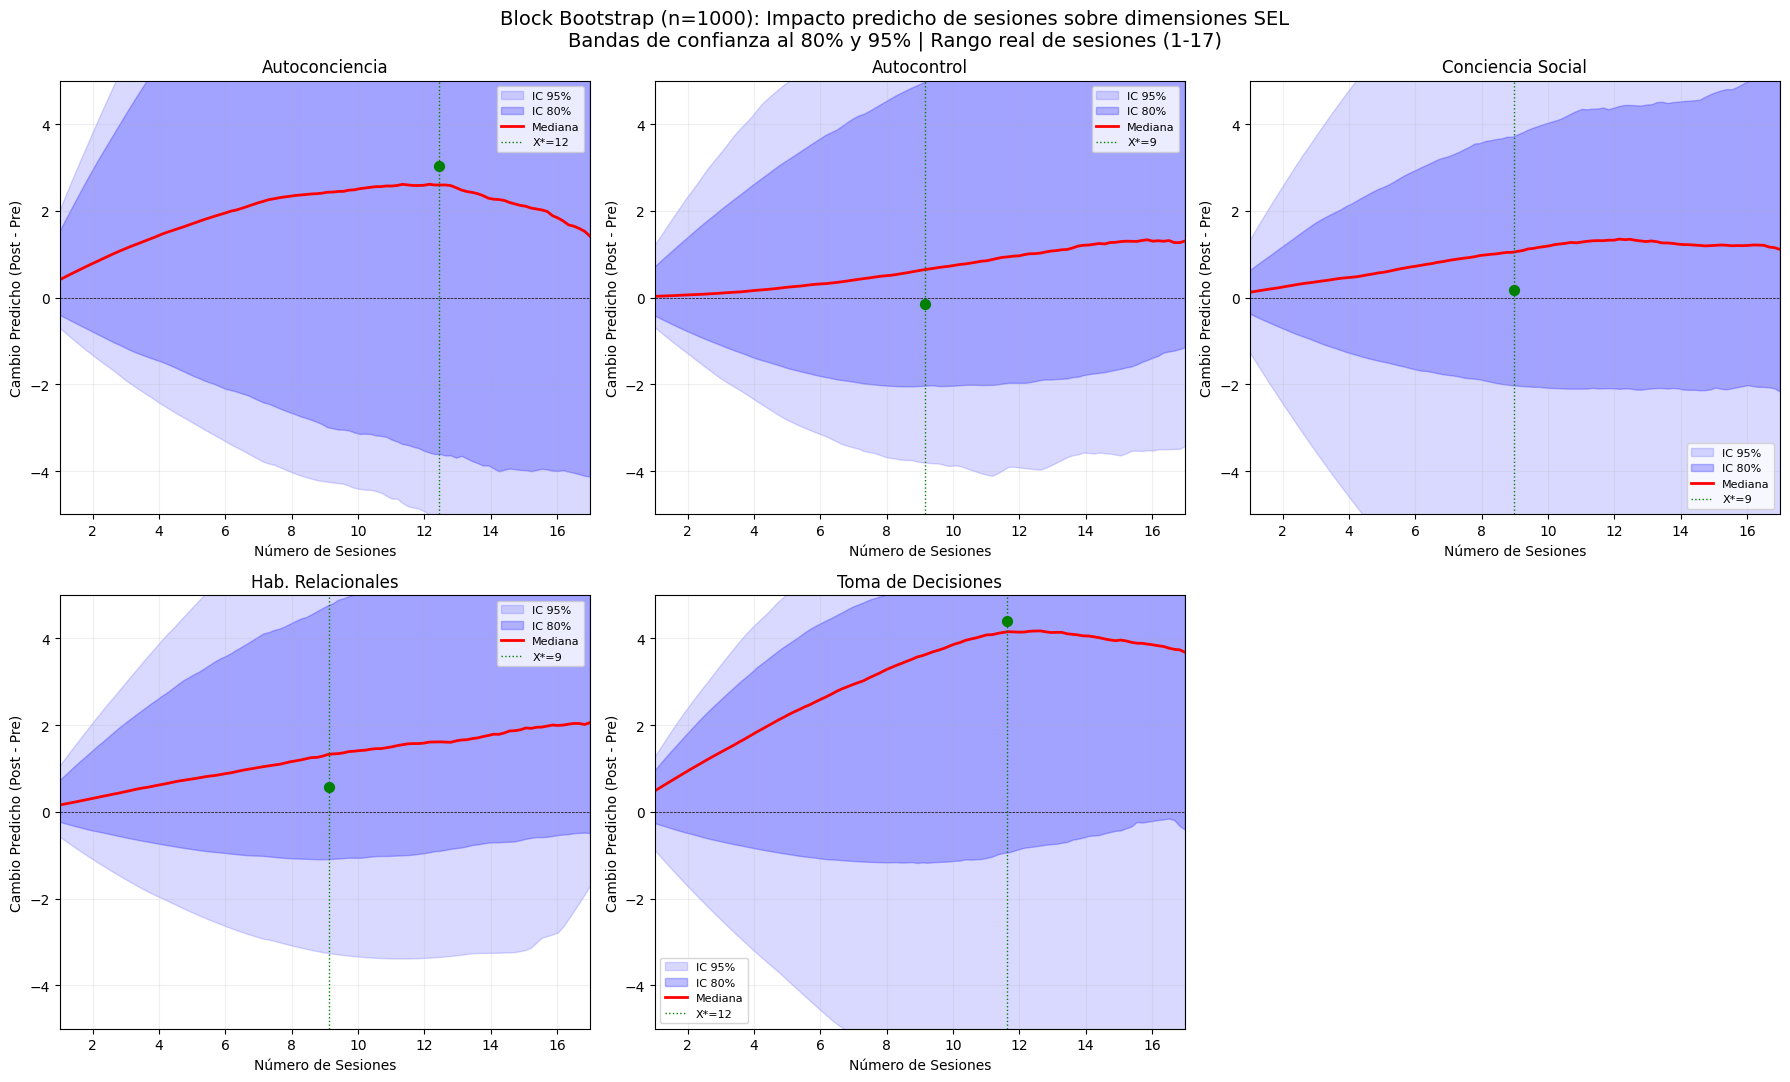

In [58]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(1, 17, 100)

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

for i, (label, res) in enumerate(results.items()):
    ax = axes[i]
    b1_arr = res['b1']
    b2_arr = res['b2']
    
    curves = np.array([b1 * X + b2 * X**2 for b1, b2 in zip(b1_arr, b2_arr)])
    
    med = np.median(curves, axis=0)
    ci_lo = np.percentile(curves, 2.5, axis=0)
    ci_hi = np.percentile(curves, 97.5, axis=0)
    ci10 = np.percentile(curves, 10, axis=0)
    ci90 = np.percentile(curves, 90, axis=0)
    
    ax.fill_between(X, ci_lo, ci_hi, alpha=0.15, color='blue', label='IC 95%')
    ax.fill_between(X, ci10, ci90, alpha=0.25, color='blue', label='IC 80%')
    ax.plot(X, med, color='red', linewidth=2, label='Mediana')
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    x_opt_med = np.median(res['x_opt'])
    y_opt_med = np.median(res['y_opt'])
    if 1 <= x_opt_med <= 17:
        ax.axvline(x_opt_med, color='green', linewidth=1, linestyle=':', label=f'X*={x_opt_med:.0f}')
        ax.scatter([x_opt_med], [y_opt_med], color='green', zorder=5, s=50)
    
    ax.set_xlabel('Número de Sesiones')
    ax.set_ylabel('Cambio Predicho (Post - Pre)')
    ax.set_title(f'{label}')
    ax.legend(fontsize=8)
    ax.set_xlim(1, 17)
    ax.set_ylim(-5, 5)
    ax.grid(True, alpha=0.2)

axes[5].set_visible(False)
plt.suptitle('Block Bootstrap (n=1000): Impacto predicho de sesiones sobre dimensiones SEL\nBandas de confianza al 80% y 95% | Rango real de sesiones (1-17)', fontsize=14)
plt.tight_layout()
plt.show()

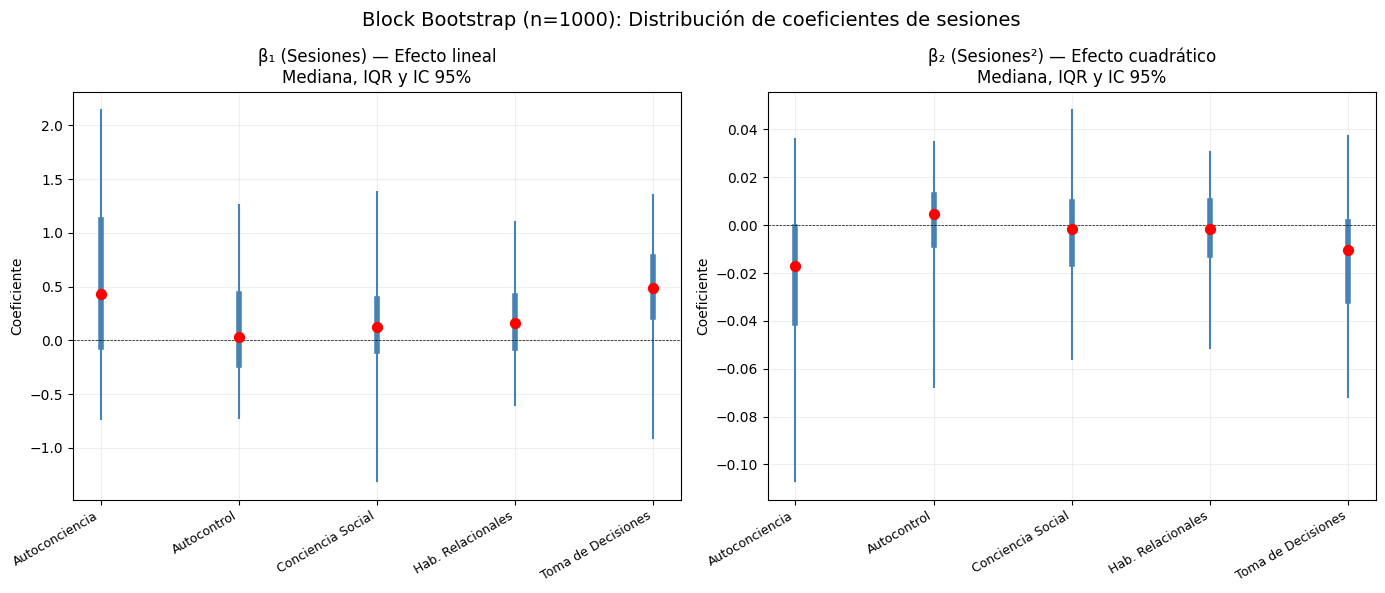

In [59]:
import numpy as np
import matplotlib.pyplot as plt

labels = list(results.keys())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: b1 (lineal)
ax = axes[0]
for i, label in enumerate(labels):
    b1 = results[label]['b1']
    med = np.median(b1)
    ci_lo, ci_hi = np.percentile(b1, [2.5, 97.5])
    q1, q3 = np.percentile(b1, [25, 75])
    
    ax.plot([i, i], [ci_lo, ci_hi], color='steelblue', linewidth=1.5)
    ax.plot([i, i], [q1, q3], color='steelblue', linewidth=4)
    ax.scatter([i], [med], color='red', zorder=5, s=50)

ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Coeficiente')
ax.set_title('β₁ (Sesiones) — Efecto lineal\nMediana, IQR y IC 95%')
ax.grid(True, alpha=0.2)

# Panel 2: b2 (cuadrático)
ax = axes[1]
for i, label in enumerate(labels):
    b2 = results[label]['b2']
    med = np.median(b2)
    ci_lo, ci_hi = np.percentile(b2, [2.5, 97.5])
    q1, q3 = np.percentile(b2, [25, 75])
    
    ax.plot([i, i], [ci_lo, ci_hi], color='steelblue', linewidth=1.5)
    ax.plot([i, i], [q1, q3], color='steelblue', linewidth=4)
    ax.scatter([i], [med], color='red', zorder=5, s=50)

ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Coeficiente')
ax.set_title('β₂ (Sesiones²) — Efecto cuadrático\nMediana, IQR y IC 95%')
ax.grid(True, alpha=0.2)

plt.suptitle('Block Bootstrap (n=1000): Distribución de coeficientes de sesiones', fontsize=14)
plt.tight_layout()
plt.show()

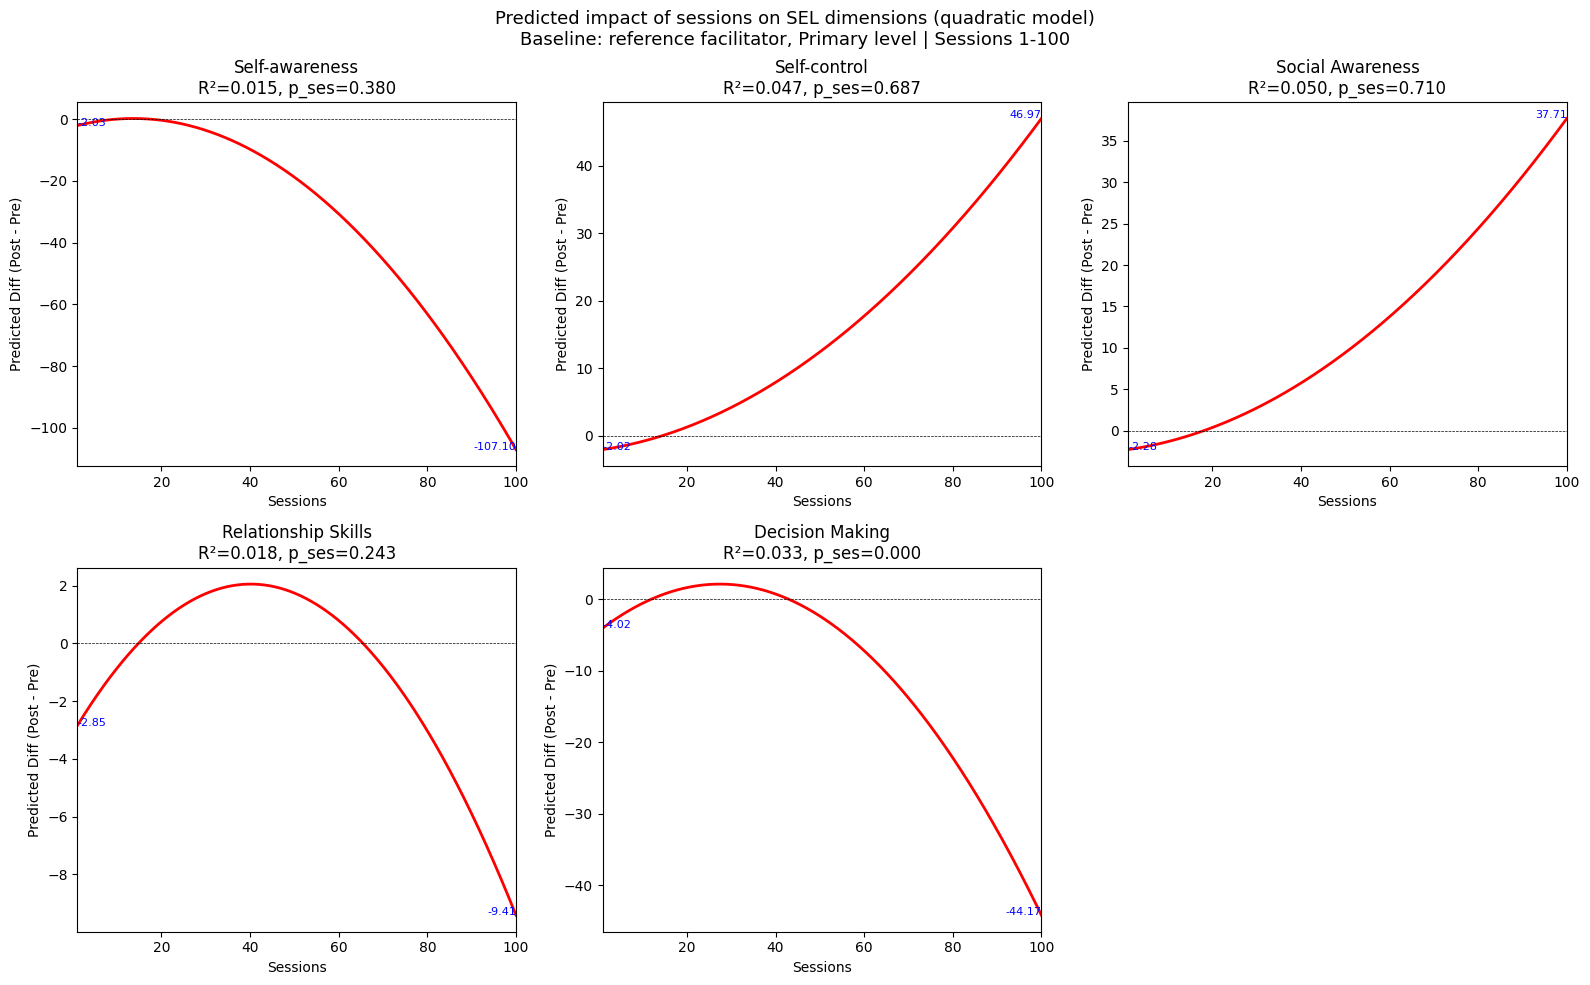

In [169]:
import numpy as np
import matplotlib.pyplot as plt

coefs = {
    'Self-awareness':      (-2.4099, 0.3931, -0.0144),
    'Self-control':        (-2.1103, 0.0908,  0.0040),
    'Social Awareness':    (-2.3586, 0.0707,  0.0033),
    'Relationship Skills': (-3.0993, 0.2569, -0.0032),
    'Decision Making':     (-4.4985, 0.4833, -0.0088),
}

pvals_lin = [0.380, 0.687, 0.710, 0.243, 0.000]
r2 = [0.015, 0.047, 0.050, 0.018, 0.033]

x = np.linspace(1, 100, 500)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, (label, (b0, b1, b2)) in enumerate(coefs.items()):
    y = b0 + b1 * x + b2 * x**2
    
    ax = axes[i]
    ax.plot(x, y, color='red', linewidth=2)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Predicted Diff (Post - Pre)')
    ax.set_title(f'{label}\nR²={r2[i]:.3f}, p_ses={pvals_lin[i]:.3f}')
    ax.set_xlim(1, 100)
    
    y1 = b0 + b1*1 + b2*1**2
    y100 = b0 + b1*100 + b2*100**2
    ax.annotate(f'{y1:.2f}', (1, y1), fontsize=8, color='blue')
    ax.annotate(f'{y100:.2f}', (100, y100), fontsize=8, color='blue', ha='right')

axes[5].set_visible(False)
plt.suptitle('Predicted impact of sessions on SEL dimensions (quadratic model)\nBaseline: reference facilitator, Primary level | Sessions 1-100', fontsize=13)
plt.tight_layout()
plt.show()

In [170]:
coefs = {
    'Self-awareness':      (0.3931, -0.0144),
    'Self-control':        (0.0908,  0.0040),
    'Social Awareness':    (0.0707,  0.0033),
    'Relationship Skills': (0.2569, -0.0032),
    'Decision Making':     (0.4833, -0.0088),
}

print(f"{'Dimensión':<25} {'b1':>8} {'b2':>8} {'X* óptimo':>10} {'Y* máximo':>10} {'Tipo':>12}")
print('='*75)

for label, (b1, b2) in coefs.items():
    x_opt = -b1 / (2 * b2)
    y_opt = b1 * x_opt + b2 * x_opt**2
    tipo = 'Máximo' if b2 < 0 else 'Mínimo (↑)'
    print(f"{label:<25} {b1:>8.4f} {b2:>8.4f} {x_opt:>10.1f} {y_opt:>10.4f} {tipo:>12}")

Dimensión                       b1       b2  X* óptimo  Y* máximo         Tipo
Self-awareness              0.3931  -0.0144       13.6     2.6828       Máximo
Self-control                0.0908   0.0040      -11.3    -0.5153   Mínimo (↑)
Social Awareness            0.0707   0.0033      -10.7    -0.3787   Mínimo (↑)
Relationship Skills         0.2569  -0.0032       40.1     5.1561       Máximo
Decision Making             0.4833  -0.0088       27.5     6.6358       Máximo
